# Homework 2: More Exploratory Data Analysis
## Gene Expression Data and Election Polls 

Due: Thursday, October 2, 2014 11:59 PM

<a href=https://raw.githubusercontent.com/cs109/2014/master/homework/HW2.ipynb download=HW2.ipynb> Download this assignment</a>

#### Submission Instructions
To submit your homework, create a folder named lastname_firstinitial_hw# and place your IPython notebooks, data files, and any other files in this folder. Your IPython Notebooks should be completely executed with the results visible in the notebook. We should not have to run any code. Compress the folder (please use .zip compression) and submit to the CS109 dropbox in the appropriate folder. If we cannot access your work because these directions are not followed correctly, we will not grade your work.


---

## Introduction

John Tukey wrote in [Exploratory Data Analysis, 1977](http://www.amazon.com/Exploratory-Data-Analysis-Wilder-Tukey/dp/0201076160/ref=pd_bbs_sr_2/103-4466654-5303007?ie=UTF8&s=books&qid=1189739816&sr=8-2): "The greatest value of a picture is when it forces us to notice what we never expected to see." In this assignment we will continue using our exploratory data analysis tools, but apply it to new sets of data: [gene expression](http://en.wikipedia.org/wiki/Gene_expression) and polls from the [2012 Presidental Election](http://en.wikipedia.org/wiki/United_States_presidential_election,_2012) and from the [2014 Senate Midterm Elections](http://en.wikipedia.org/wiki/United_States_Senate_elections,_2014).   

**First**: You will use exploratory data analysis and apply the [singular value decomposition](http://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) to a gene expression data matrix to determine if the the date that the gene expression samples are processed has large effect on the variability seen in the data.  

**Second**: You will use the polls from the 2012 Presidential Elections to determine (1) Is there a pollster bias in presidential election polls? and (2) Is the average of polls better than just one poll?

**Finally**: You will use the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to extract the polls for the current 2014 Senate Midterm Elections and provide a preliminary prediction of the result of each state.

#### Data

We will use the following data sets: 

1. A gene expression data set called `exprs_GSE5859.csv` and sample annotation table called `sampleinfo_GSE5859.csv` which are both available on Github in the 2014_data repository: [expression data set](https://github.com/cs109/2014_data/blob/master/exprs_GSE5859.csv) and [sample annotation table](https://github.com/cs109/2014_data/blob/master/sampleinfo_GSE5859.csv).  

2. Polls from the [2012 Presidential Election: Barack Obama vs Mitt Romney](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama). The polls we will use are from the [Huffington Post Pollster](http://elections.huffingtonpost.com/pollster).  

3. Polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api). 

---

## Load Python modules

In [229]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import requests 
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
import datetime as dt # module for manipulating dates and times
import numpy.linalg as lin # module for performing linear algebra operations
import seaborn as sns
import scipy.stats as stats
from io import StringIO

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Problem 1

In this problem we will be using a [gene expression](http://en.wikipedia.org/wiki/Gene_expression) data set obtained from a [microarray](http://en.wikipedia.org/wiki/DNA_microarray) experiement [Read more about the specific experiment here](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE5859).  There are two data sets we will use:  

1. The gene expression intensities where the rows represent the features on the microarray (e.g. genes) and the columsns represent the different microarray samples.  

2. A table that contains the information about each of the samples (columns in the gene expression data set) such as the sex, the age, the treatment status, the date the samples were processed.  Each row represents one sample. 

#### Problem 1(a) 
Read in the two files from Github: [exprs_GSE5859.csv](https://github.com/cs109/2014_data/blob/master/exprs_GSE5859.csv) and [sampleinfo_GSE5859.csv](https://github.com/cs109/2014_data/blob/master/sampleinfo_GSE5859.csv) as pandas DataFrames called `exprs` and `sampleinfo`. Use the gene names as the index of the `exprs` DataFrame.

In [195]:
exprs = pd.read_csv('data/HW2/exprs_GSE5859.csv')
sampleinfo = pd.read_csv('data/HW2/sampleinfo_GSE5859.csv')

exprs.index = exprs['Unnamed: 0']
del exprs['Unnamed: 0']

exprs.head(3)
sampleinfo.head(3)

,GSM25581.CEL.gz,GSM25681.CEL.gz,GSM136524.CEL.gz,GSM136707.CEL.gz,GSM25553.CEL.gz,GSM136676.CEL.gz,GSM136711.CEL.gz,GSM136542.CEL.gz,GSM136535.CEL.gz,GSM25399.CEL.gz,...,GSM48650.CEL.gz,GSM25687.CEL.gz,GSM25685.CEL.gz,GSM136549.CEL.gz,GSM25427.CEL.gz,GSM25525.CEL.gz,GSM25349.CEL.gz,GSM136727.CEL.gz,GSM25626.CEL.gz,GSM136725.CEL.gz
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1007_s_at,6.333951,5.736190,6.156754,6.513010,6.061013,6.506493,6.863426,6.369645,6.646321,5.810930,...,7.082636,6.315866,7.010165,6.460107,6.122355,6.330314,6.627014,6.133068,6.419444,6.488579
1053_at,7.255622,7.399993,7.491967,7.006123,7.250995,7.082581,6.842236,7.048487,7.042361,6.666625,...,6.599718,7.412731,7.274429,6.928642,7.168782,7.235648,6.939184,7.280781,6.351776,7.517410
117_at,5.760106,4.825169,5.039387,5.414160,5.205697,5.300078,5.099337,5.156459,5.736109,5.807496,...,6.231457,5.240717,5.275062,5.759827,5.409720,5.491938,5.113570,5.401876,5.537605,5.247190


,ethnicity,date,filename,sex
0,CEU,2003-02-04,GSM25349.CEL.gz,M
1,CEU,2003-02-04,GSM25350.CEL.gz,M
2,CEU,2002-12-17,GSM25356.CEL.gz,M


Make sure the order of the columns in the gene expression DataFrame match the order of file names in the sample annotation DataFrame. If the order of the columns the `exprs` DataFrame do not match the order of the file names in the `sampleinfo` DataFrame, reorder the columns in the `exprs` DataFrame. 

**Note**: The column names of the gene expression DataFrame are the filenames of the orignal files from which these data were obtained.  

**Hint**: The method `list.index(x)` [[read here](https://docs.python.org/2/tutorial/datastructures.html)] can be used to return the index in the list of the first item whose value is x. It is an error if there is no such item. To check if the order of the columns in `exprs` matches the order of the rows in `sampleinfo`, you can check using the method `.all()` on a Boolean or list of Booleans: 

Example code: `(exprs.columns == sampleinfo.filename).all()`

In [43]:
exprs.sort_index(axis=1, inplace=True)
sampleinfo.sort_values(by='filename', inplace=True)
(exprs.columns == sampleinfo.filename).all()

True

Show the head of the two tables: `exprs` and `sampleinfo`. 

In [45]:
exprs.head(3)
sampleinfo.head(3)

,GSM136441.CEL.gz,GSM136442.CEL.gz,GSM136443.CEL.gz,GSM136444.CEL.gz,GSM136445.CEL.gz,GSM136506.CEL.gz,GSM136507.CEL.gz,GSM136508.CEL.gz,GSM136509.CEL.gz,GSM136510.CEL.gz,...,GSM48655.CEL.gz,GSM48656.CEL.gz,GSM48657.CEL.gz,GSM48658.CEL.gz,GSM48660.CEL.gz,GSM48661.CEL.gz,GSM48662.CEL.gz,GSM48663.CEL.gz,GSM48664.CEL.gz,GSM48665.CEL.gz
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1007_s_at,6.302996,6.444051,6.238090,6.499574,6.454842,6.171587,6.517539,6.543954,6.379983,6.502051,...,6.237984,6.704893,6.720599,6.501510,6.558100,6.618286,6.869995,5.981000,6.403285,6.248702
1053_at,7.097359,7.099125,7.308965,6.889842,6.880901,7.123658,7.689282,7.546708,7.702533,7.302209,...,7.169030,6.658916,7.280992,7.066686,7.386702,6.407958,7.089180,7.120923,7.018998,7.155419
117_at,5.204992,5.448902,5.440455,5.386826,5.147856,5.298285,5.562001,5.402622,5.398616,5.395087,...,5.095864,5.308445,5.347524,5.600514,5.232676,5.630720,4.944748,5.275577,5.770358,5.616842


,ethnicity,date,filename,sex
99,ASN,2005-05-13,GSM136441.CEL.gz,F
100,ASN,2005-06-10,GSM136442.CEL.gz,F
101,ASN,2005-06-10,GSM136443.CEL.gz,M


#### Problem 1(b)

Extract the year and month as integers from the `sampleinfo` table. 

**Hint**: To convert a Series or a column of a pandas DataFrame that contains a date-like object, you can use the `to_datetime` function [[read here](http://pandas.pydata.org/pandas-docs/stable/timeseries.html)].  This will create a `DatetimeIndex` which can be used to extract the month and year for each row in the DataFrame. 

In [52]:
sampleinfo.date = pd.to_datetime(sampleinfo.date)
months = sampleinfo.date.dt.month
years = sampleinfo.date.dt.year
months[:2]
years[:2]

99     5
100    6
Name: date, dtype: int64

99     2005
100    2005
Name: date, dtype: int64

#### Problem 1(c)

Convert the dates in the `date` column from the `sampleinfo` table into days since October 31, 2002. Add a column to the `sampleinfo` DataFrame titled `elapsedInDays` containing the days since October 31, 2002.  Show the head of the `sampleinfo` DataFrame which includes the new column.  

**Hint**: Use the `datetime` module to create a new `datetime` object for the specific date October 31, 2002. Then, subtract the October 31, 2002 date from each date from the `date` column in the `sampleinfo` DataFrame. 

In [160]:
dateToSubstract = pd.to_datetime('2002-10-31')
sampleinfo['elapsedInDays'] = sampleinfo.date - dateToSubstract
sampleinfo.elapsedInDays = sampleinfo.elapsedInDays.dt.days
sampleinfo.head(10)

,ethnicity,date,filename,sex,elapsedInDays
99,ASN,2005-05-13,GSM136441.CEL.gz,F,925
100,ASN,2005-06-10,GSM136442.CEL.gz,F,953
101,ASN,2005-06-10,GSM136443.CEL.gz,M,953
102,ASN,2005-06-10,GSM136444.CEL.gz,M,953
103,ASN,2005-06-10,GSM136445.CEL.gz,F,953
104,ASN,2005-06-10,GSM136506.CEL.gz,M,953
105,ASN,2005-06-23,GSM136507.CEL.gz,M,966
106,ASN,2005-06-23,GSM136508.CEL.gz,M,966
107,ASN,2005-06-23,GSM136509.CEL.gz,M,966
108,ASN,2005-06-23,GSM136510.CEL.gz,M,966


#### Problem 1(d)

Use exploratory analysis and the singular value decomposition (SVD) of the gene expression data matrix to determine if the date the samples were processed has large effect on the variability seen in the data or if it is just ethnicity (which is confounded with date). 

**Hint**: See the end of the [lecture from 9/23/2014 for help with SVD](http://nbviewer.ipython.org/github/cs109/2014/blob/master/lectures/lecture07/data_scraping_transcript.ipynb). 

First subset the the `sampleinfo` DataFrame to include only the CEU ethnicity.  Call this new subsetted DataFrame `sampleinfoCEU`.  Show the head of `sampleinfoCEU` DataFrame. 

In [161]:
sampleinfoCEU = sampleinfo[sampleinfo.ethnicity == 'CEU']
sampleinfoCEU.head(2)
sampleinfoCEU.shape

,ethnicity,date,filename,sex,elapsedInDays
204,CEU,2005-02-16,GSM136725.CEL.gz,F,839
205,CEU,2005-02-16,GSM136726.CEL.gz,M,839


(102, 5)

Next, subset the `exprs` DataFrame to only include the samples with the CEU ethnicity. Name this new subsetted DataFrame `exprsCEU`. Show the head of the `exprsCEU` DataFrame. 

In [162]:
columns = exprs.columns.isin(sampleinfoCEU.filename.values)
exprsCEU = exprs.loc[:,columns]
exprsCEU.head(2)
exprsCEU.shape

,GSM136725.CEL.gz,GSM136726.CEL.gz,GSM136727.CEL.gz,GSM25349.CEL.gz,GSM25350.CEL.gz,GSM25356.CEL.gz,GSM25357.CEL.gz,GSM25358.CEL.gz,GSM25359.CEL.gz,GSM25360.CEL.gz,...,GSM48655.CEL.gz,GSM48656.CEL.gz,GSM48657.CEL.gz,GSM48658.CEL.gz,GSM48660.CEL.gz,GSM48661.CEL.gz,GSM48662.CEL.gz,GSM48663.CEL.gz,GSM48664.CEL.gz,GSM48665.CEL.gz
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1007_s_at,6.488579,6.809481,6.133068,6.627014,6.249807,5.934128,6.145268,6.091270,6.041186,6.050375,...,6.237984,6.704893,6.720599,6.501510,6.558100,6.618286,6.869995,5.981000,6.403285,6.248702
1053_at,7.517410,7.200596,7.280781,6.939184,6.818038,7.047962,7.422477,7.272361,7.128216,6.750719,...,7.169030,6.658916,7.280992,7.066686,7.386702,6.407958,7.089180,7.120923,7.018998,7.155419


(8793, 102)

Check to make sure the order of the columns in the `exprsCEU` DataFrame matches the rows in the `sampleinfoCEU` DataFrame.  

In [163]:
(exprsCEU.columns == sampleinfoCEU.filename).all()

True

Compute the average gene expression intensity in the `exprsCEU` DataFrame across all the samples. For each sample in the `exprsCEU` DataFrame, subtract the average gene expression intensity from each of the samples. Show the head of the mean normalized gene expression data.  

In [191]:
exprsCEUMeanNormalized = exprsCEU.apply(lambda x: x - exprsCEU.mean(axis=1), axis = 0)
exprsCEUMeanNormalized.head(2)
exprsCEUMeanNormalized.shape

,GSM136725.CEL.gz,GSM136726.CEL.gz,GSM136727.CEL.gz,GSM25349.CEL.gz,GSM25350.CEL.gz,GSM25356.CEL.gz,GSM25357.CEL.gz,GSM25358.CEL.gz,GSM25359.CEL.gz,GSM25360.CEL.gz,...,GSM48655.CEL.gz,GSM48656.CEL.gz,GSM48657.CEL.gz,GSM48658.CEL.gz,GSM48660.CEL.gz,GSM48661.CEL.gz,GSM48662.CEL.gz,GSM48663.CEL.gz,GSM48664.CEL.gz,GSM48665.CEL.gz
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1007_s_at,0.226624,0.547526,-0.128887,0.365059,-0.012149,-0.327827,-0.116687,-0.170685,-0.220769,-0.211580,...,-0.023971,0.442938,0.458643,0.239554,0.296144,0.356331,0.608040,-0.280956,0.141330,-0.013254
1053_at,0.442193,0.125379,0.205564,-0.136032,-0.257178,-0.027254,0.347260,0.197144,0.053000,-0.324497,...,0.093813,-0.416301,0.205776,-0.008531,0.311485,-0.667259,0.013964,0.045706,-0.056219,0.080203


(8793, 102)

Using this mean normalized gene expression data, compute the projection to the first Principal Component (PC1).  

**Hint**: Use the `numpy.linalg.svd()` function in the `numpy.linalg` module (or the `scipy.linalg.svd()` function in the `scipy.linalg` module) to apply an [singular value decomposition](http://en.wikipedia.org/wiki/Singular_value_decomposition) to a matrix.  

In [133]:
U,s,Vh = lin.svd(exprsCEUMeanNormalized.values)
V = Vh.T

In [177]:
exprsCEUMeanNormalized.shape

(8793, 102)

In [189]:
U.shape
s.shape
Vh.shape

(8793, 8793)

(102,)

(102, 102)

Create a histogram using the values from PC1.  Use a bin size of 25.  

(array([  2.,   0.,   2.,   3.,  10.,   5.,   6.,   5.,   8.,   6.,   1.,
          3.,   2.,   8.,   7.,   3.,   9.,   6.,   3.,   3.,   4.,   2.,
          1.,   1.,   2.]),
 array([-0.19476468, -0.17820174, -0.1616388 , -0.14507587, -0.12851293,
        -0.11194999, -0.09538705, -0.07882411, -0.06226117, -0.04569823,
        -0.02913529, -0.01257235,  0.00399058,  0.02055352,  0.03711646,
         0.0536794 ,  0.07024234,  0.08680528,  0.10336822,  0.11993116,
         0.13649409,  0.15305703,  0.16961997,  0.18618291,  0.20274585,
         0.21930879]),
 <a list of 25 Patch objects>)

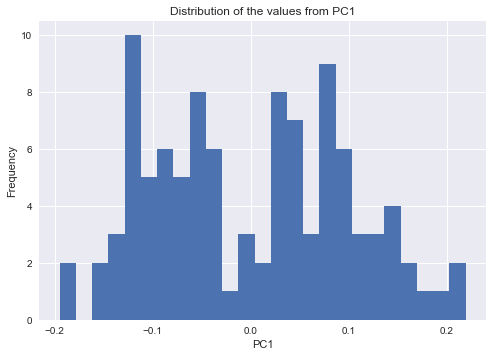

In [134]:
plt.hist(V[:,0], bins = 25)
plt.xlabel('PC1')
plt.ylabel('Frequency')
plt.title('Distribution of the values from PC1')

Create a scatter plot with the days since October 31, 2002 on the x-axis and PC1 on the y-axis.

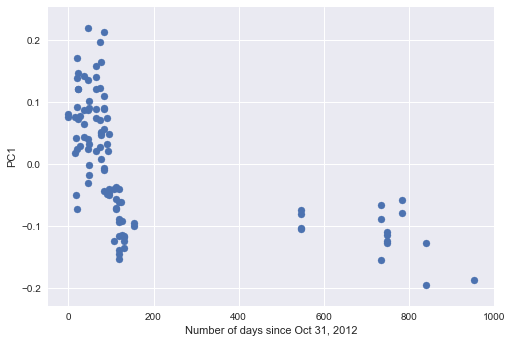

In [171]:
plt.scatter(sampleinfoCEU.elapsedInDays, V[:,0])
plt.xlabel('Number of days since Oct 31, 2012')
plt.ylabel('PC1')

(0, 160)

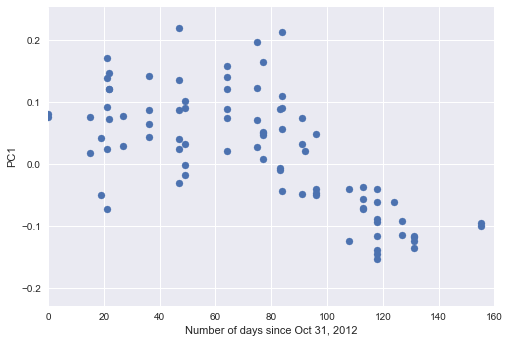

In [172]:
plt.scatter(sampleinfoCEU.elapsedInDays, V[:,0])
plt.xlabel('Number of days since Oct 31, 2012')
plt.ylabel('PC1')
plt.xlim(0,160)

Around what day do you notice a difference in the way the samples were processed?

There is a visible change in way samples were processed around 105-110 day since Oct 31, 2012.

## Discussion for Problem 1

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

---


## Problem 2: Is there a pollster bias in presidential election polls?

#### Problem 2(a)

The [HuffPost Pollster](http://elections.huffingtonpost.com/pollster) contains many political polls. You can access these polls from individual races as a CSV but you can also access polls through the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to access the data.  

Read in the polls from the [2012 Presidential Election: Barack Obama vs Mitt Romney](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama) into a pandas DataFrame called `election`. For this problem, you may read in the polls for this race directly using [the CSV file](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv) available from the HuffPost Pollster page.

In [16]:
election = pd.read_csv('data/HW2/2012-general-election-romney-vs-obama.csv')
election.head(2)

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Other,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06T08:40:26Z,1000.0,Likely Voters,Live Phone,47.0,47.0,6.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None,NaN,1
1,YouGov/Economist,2012-11-03,2012-11-05,2012-11-26T15:31:23Z,740.0,Likely Voters,Internet,49.0,47.0,3.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://cdn.yougov.com/cumulus_uploads/document...,Nonpartisan,None,NaN,1


How many polls were conducted in November? Define this number as M.  

**Hint**: Subset the `election` DataFrame for only dates in the `Start Date` column that are in November 2012.  

In [17]:
election['StartDate'] = pd.to_datetime(election['Start Date'])
del election['Start Date']
election['EndDate'] = pd.to_datetime(election['End Date'])
del election['End Date']

In [18]:
election.shape
condition = (election.StartDate >= pd.to_datetime('2012-11'))\
            & (election.StartDate < pd.to_datetime('2012-12'))
nov_polls = election[condition]
nov_polls.drop_duplicates('Pollster', inplace = True)
nov_polls.shape
M = nov_polls.shape[0]
M

(586, 17)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


(18, 17)

18

Answer: 18 polls were conducted in November 2012.

What was the median of the number of observations in the November polls? Define this quantity as N. 

In [33]:
N = nov_polls['Number of Observations'].median()
N

1200.0

Answer: Median of the number of observations in the November polls is: 1200

#### Problem 2(b)

Using the median sample size $N$ from Problem 1(a), simulate the results from a single poll:  simulate the number of votes for Obama out of a sample size $N$ where $p$ = 0.53 is the percent of voters who are voting for Obama.  

**Hint**: Use the binomial distribution with parameters $N$ and $p$ = 0.53. 

Now, perform a Monte Carlo simulation to obtain the estimated percentage of Obama votes with a sample size $N$ where $N$ is the median sample size calculated in Problem 2(a). Let $p$=0.53 be the percent of voters are voting for Obama. 

**Hint**: You will repeat the simulation above 1,000 times and plot the distribution of the estimated *percent* of Obama votes from a single poll.  The results from the single poll you simulate is random variable and will be different every time you sample. 

In [474]:
sampleSize = 1000
p = 0.53
np.mean(np.random.binomial(1, p, size = sampleSize))

0.51900000000000002

In [70]:
p = 0.53
sampleSize = 1000
function = lambda x: np.mean(np.random.binomial(1, p, size = sampleSize))
simulation = list(map(function, range(sampleSize)))

Plot the distribution of the estimated percentage of Obama votes from your single poll. What is the distribution of the estimated percentage of Obama votes? 

(array([  11.,   34.,   75.,  166.,  200.,  249.,  152.,   67.,   38.,    8.]),
 array([ 0.484 ,  0.4932,  0.5024,  0.5116,  0.5208,  0.53  ,  0.5392,
         0.5484,  0.5576,  0.5668,  0.576 ]),
 <a list of 10 Patch objects>)

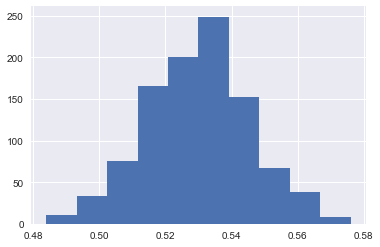

In [71]:
plt.hist(simulation)

In [72]:
stats.normaltest(simulation)

NormaltestResult(statistic=0.70750247245501885, pvalue=0.70204959013910084)

NormalTest returns a 2-tuple of the chi-squared statistic, and the associated p-value. Given the null hypothesis that x came from a normal distribution, the p-value represents the probability that a chi-squared statistic that large (or larger) would be seen.

In [73]:
df = pd.DataFrame(simulation)
df.columns = ['simulationMean']
df.describe()

,simulationMean
count,1000.000000
mean,0.529703
std,0.015601
min,0.484000
25%,0.519000
50%,0.530000
75%,0.540000
max,0.576000


In [388]:
np.sqrt((0.53 * 0.47) / 1200)

0.014407752542757436

What is the distribution of the estimated percentage of Obama votes?

Answer: 

In [74]:
print('Standard deviation is :', df.simulationMean.std())

Standard deviation is : 0.01560128812602318


The NumPy function np.std takes an optional parameter ddof: **"Delta Degrees of Freedom"**. By default, this is 0. Set it to 1 to get the MATLAB result:

```
p.std([1,3,4,6], ddof=1)
2.0816659994661326
```

To add a little more context, in the calculation of the variance (of which the standard deviation is the square root) we typically divide by the number of values we have.

But if we select a random sample of N elements from a larger distribution and calculate the variance, division by N can lead to an underestimate of the actual variance. To fix this, we can lower the number we divide by (the degrees of freedom) to a number less than N (usually N-1). The ddof parameter allows us change the divisor by the amount we specify.

Unless told otherwise, NumPy will calculate the biased estimator for the variance (ddof=0, dividing by N). This is what you want if you are working with the entire distribution (and not a subset of values which have been randomly picked from a larger distribution). If the ddof parameter is given, NumPy divides by N - ddof instead.

The default behaviour of MATLAB's std is to correct the bias for sample variance by dividing by N-1. This gets rid of some of (but probably not all of) of the bias in the standard deviation. This is likely to be what you want if you're using the function on a random sample of a larger distribution.

[Answears on stack](http://stackoverflow.com/questions/27600207/why-does-numpy-std-give-a-different-result-to-matlab-std)

What is the standard error (SE) of the estimated percentage from the poll. 

**Hint**: Remember the SE is the standard deviation (SD) of the distribution of a random variable. 

In [27]:
print('Standard deviation is :', df.simulationMean.std(ddof=1))

Standard deviation is : 0.01591964780345931


#### Problem 2(c)

Now suppose we run M polls where M is the number of polls that happened in November (calculated in Problem 2(a)). Run 1,000 simulations and compute the mean of the M polls for each simulation. 

In [34]:
M
N

18

1200.0

In [3]:
def runPollSimulation(times, sampleSize, p):
    """
    Function is running poll simulation n-times
    and returns a list of means of every simulation
    with sampleSize number of votes. Used distribution
    is binomial with probability p.
    """
    return list(map(lambda x: np.mean(np.random.binomial(1, p, size = sampleSize)), range(times)))

In [60]:
p = 0.53
sampleSize = 1000
pollSimulation = runPollSimulation(M, sampleSize, p)
pollSimulation

[0.56299999999999994,
 0.53200000000000003,
 0.52300000000000002,
 0.502,
 0.51700000000000002,
 0.54700000000000004,
 0.53300000000000003,
 0.54500000000000004,
 0.53500000000000003,
 0.51000000000000001,
 0.51300000000000001,
 0.51000000000000001,
 0.53100000000000003,
 0.51400000000000001,
 0.54800000000000004,
 0.51700000000000002,
 0.52700000000000002,
 0.52600000000000002]

In [66]:
p = 0.53
sampleSize = 1000
pollSimulation = list(map(lambda y: np.mean(runPollSimulation(M, sampleSize, p)), range(sampleSize)))
pollSimulation

[0.5290555555555555,
 0.53227777777777774,
 0.53327777777777774,
 0.52883333333333338,
 0.52977777777777779,
 0.53505555555555562,
 0.53333333333333333,
 0.53549999999999998,
 0.53761111111111104,
 0.52994444444444444,
 0.5317777777777779,
 0.53750000000000009,
 0.52994444444444444,
 0.52422222222222226,
 0.53155555555555567,
 0.53455555555555567,
 0.53455555555555567,
 0.53027777777777774,
 0.5314444444444445,
 0.52849999999999997,
 0.52722222222222226,
 0.52888888888888896,
 0.5243888888888889,
 0.53016666666666667,
 0.53527777777777785,
 0.5347777777777778,
 0.5357777777777778,
 0.52627777777777796,
 0.52994444444444455,
 0.52955555555555556,
 0.5297777777777779,
 0.53016666666666667,
 0.52788888888888896,
 0.53161111111111103,
 0.52655555555555555,
 0.53472222222222221,
 0.53488888888888886,
 0.53822222222222216,
 0.5304444444444445,
 0.52849999999999997,
 0.53072222222222232,
 0.53255555555555556,
 0.53050000000000008,
 0.53388888888888886,
 0.53422222222222215,
 0.534277777777777

What is the distribution of the average of polls?

**Hint**: Show a plot. 

(array([  13.,   35.,  107.,  198.,  254.,  206.,  132.,   42.,   11.,    2.]),
 array([ 0.51988889,  0.52213889,  0.52438889,  0.52663889,  0.52888889,
         0.53113889,  0.53338889,  0.53563889,  0.53788889,  0.54013889,
         0.54238889]),
 <a list of 10 Patch objects>)

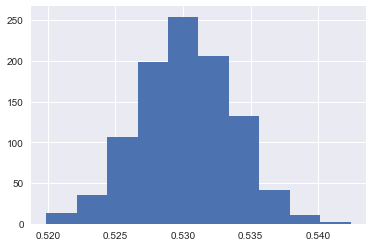

In [67]:
plt.hist(pollSimulation)

Answer: 

What is the standard error (SE) of the average of polls? 

In [76]:
df2 = pd.DataFrame(pollSimulation)
df2.columns = ['pollSimulationMean']
df2.describe()

,pollSimulationMean
count,1000.000000
mean,0.530167
std,0.003526
min,0.519889
25%,0.527778
50%,0.530056
75%,0.532556
max,0.542389


Answer: 

Is the SE of the average of polls larger, the same, or smaller than that the SD of a single poll (calculated in Problem 2(b))? By how much?

**Hint**: Compute a ratio of the two quantities.  

In [77]:
df.simulationMean.std() / df2.pollSimulationMean.std()

4.424605254993299

Answer: Simulation of single poll is 4 times bigger than this calculated in 2(c)

#### Problem 2(d) 

Repeat Problem 2(c) but now record the *across poll* standard deviation in each simulation. 

In [22]:
p = 0.53
sampleSize = 1000
pollsStd = list(map(lambda y: np.std(runPollSimulation(M, sampleSize, p)), range(sampleSize)))
pollsStd

[0.014180603166749975,
 0.019333732435216536,
 0.014003967691733347,
 0.013650396819628858,
 0.015219890332337992,
 0.020195036671737929,
 0.017391639824998379,
 0.019766616700954892,
 0.01964633286549243,
 0.018357980065866877,
 0.017083310749759252,
 0.014320946413308021,
 0.019026946453859203,
 0.012079469369426533,
 0.013412266359153819,
 0.013200378782444082,
 0.014387494569938158,
 0.012116334245783905,
 0.014099732945549105,
 0.017176372660657361,
 0.019039351711133627,
 0.016425664952622251,
 0.020273134932713297,
 0.011104581414671241,
 0.016057093351960695,
 0.011985201780879425,
 0.014230141024608551,
 0.015516319564880926,
 0.012405818029765493,
 0.010667824011287524,
 0.013779233794032876,
 0.019703747215212349,
 0.013023364568780156,
 0.012397231869441326,
 0.014381915942350653,
 0.015876160402811597,
 0.019082342688179984,
 0.016288392443548926,
 0.014449144534462149,
 0.018740923729160797,
 0.013467954650544978,
 0.015191879734797258,
 0.018586883069041531,
 0.011899917

What is the distribution of the *across M polls* standard deviation?

**Hint**: Show a plot. 

(array([   5.,   30.,  113.,  204.,  270.,  199.,  123.,   44.,   10.,    2.]),
 array([ 0.00724611,  0.00895487,  0.01066362,  0.01237238,  0.01408113,
         0.01578988,  0.01749864,  0.01920739,  0.02091614,  0.0226249 ,
         0.02433365]),
 <a list of 10 Patch objects>)

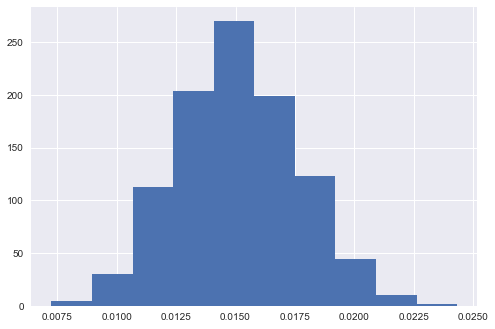

In [9]:
plt.hist(pollsStd)

In [24]:
df3 = pd.DataFrame(pollsStd)
df3.columns = ['pollStd']
df3.describe()

,pollStd
count,1000.000000
mean,0.015090
std,0.002578
min,0.007433
25%,0.013358
50%,0.015029
75%,0.016835
max,0.022986


Answer:  Distribution is again close to normal distribution

#### Problem 2(e) 

What is the standard deviation of M polls in our real (not simulated) 2012 presidential election data ? 

In [21]:
nov_polls.describe()

,Number of Observations,Obama,Romney,Undecided,Other,Question Text,Question Iteration
count,18.000000,18.000000,18.000000,12.000000,8.000000,0.0,18.0
mean,1548.333333,48.777778,47.722222,3.083333,1.375000,NaN,1.0
std,1022.319566,1.114374,1.127494,1.676486,0.517549,NaN,0.0
min,693.000000,47.000000,45.000000,1.000000,1.000000,NaN,1.0
25%,1004.750000,48.000000,47.000000,2.000000,1.000000,NaN,1.0
50%,1200.000000,49.000000,48.000000,3.000000,1.000000,NaN,1.0
75%,1493.750000,49.750000,48.750000,4.000000,2.000000,NaN,1.0
max,4725.000000,51.000000,49.000000,6.000000,2.000000,NaN,1.0


Is this larger, the same, or smaller than what we expeced if polls were not biased.

In [30]:
accual = nov_polls.Obama.std()/100
simulated = df3.pollStd.mean()

print('Accual std is: ', accual, ' whereas simulated std is: ', simulated)
print('Accual/simulated: ', accual/simulated)

Accual std is:  0.01114374293206496  whereas simulated std is:  0.015089609713051316
Accual/simulated:  0.7385043844060795


Answer: Accual std is smaller than this from simulations.

#### Problem 2(f)

**For AC209 Students**: Learn about the normal approximation for the binomial distribution and derive the results of Problem 2(b) and 2(c) analytically (using this approximation). Compare the results obtained analytically to those obtained from simulations.

In [30]:
#your code here

Answer: 

## Discussion for Problem 2

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

---


## Problem 3: Is the average of polls better than just one poll?

#### Problem 3(a)

Most undecided voters vote for one of the two candidates at the election. Therefore, the reported percentages underestimate the final value of both candidates. However, if we assume the undecided will split evenly, then the observed difference should be an unbiased estimate of the final difference. 

Add a new column to the `election` DataFrame containg the difference between Obama and Romeny called `Diff`. 

In [32]:
election['Diff'] = election.Obama - election.Romney
election.head(5)

,Pollster,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Other,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration,StartDate,EndDate,Diff
0,Politico/GWU/Battleground,2012-11-06T08:40:26Z,1000.0,Likely Voters,Live Phone,47.0,47.0,6.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None,NaN,1,2012-11-04,2012-11-05,0.0
1,YouGov/Economist,2012-11-26T15:31:23Z,740.0,Likely Voters,Internet,49.0,47.0,3.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://cdn.yougov.com/cumulus_uploads/document...,Nonpartisan,None,NaN,1,2012-11-03,2012-11-05,2.0
2,Gravis Marketing,2012-11-06T09:22:02Z,872.0,Likely Voters,Automated Phone,48.0,48.0,4.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.gravispolls.com/2012/11/gravis-mark...,Nonpartisan,None,NaN,1,2012-11-03,2012-11-05,0.0
3,IBD/TIPP,2012-11-06T08:51:48Z,712.0,Likely Voters,Live Phone,50.0,49.0,NaN,1.0,http://elections.huffingtonpost.com/pollster/p...,http://news.investors.com/special-report/50841...,Nonpartisan,None,NaN,1,2012-11-03,2012-11-05,1.0
4,Rasmussen,2012-11-06T08:47:50Z,1500.0,Likely Voters,Automated Phone,48.0,49.0,NaN,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.rasmussenreports.com/public_content...,Nonpartisan,None,NaN,1,2012-11-03,2012-11-05,-1.0


#### Problem 3(b)

Make a plot of the differences for the week before the election (e.g. 5 days) where the days are on the x-axis and the differences are on the y-axis.  Add a horizontal line showing 3.9%: the difference between Obama and Romney on election day.

In [108]:
nov_election = election[election.StartDate >= pd.to_datetime('2012.11')].copy()
nov_election.drop_duplicates('Pollster', inplace = True)

nov_election.StartDate = nov_election.StartDate.dt.date
nov_election.sort_values(by='StartDate', inplace=True)

nov_election.head(5)
nov_election.StartDate.describe()

,Pollster,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Other,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration,StartDate,EndDate,Diff
17,NBC/WSJ,2012-11-04T09:12:21Z,1475.0,Likely Voters,Live Phone,48.0,47.0,3.0,2.0,http://elections.huffingtonpost.com/pollster/p...,http://firstread.nbcnews.com/_news/2012/11/04/...,Nonpartisan,None,NaN,1,2012-11-01,2012-11-03,1.0
15,Democracy Corps (D),2012-11-05T09:41:50Z,1080.0,Likely Voters,Live Phone,49.0,45.0,NaN,1.0,http://elections.huffingtonpost.com/pollster/p...,http://big.assets.huffingtonpost.com/demcorpst...,Pollster,Dem,NaN,1,2012-11-01,2012-11-04,4.0
14,Monmouth,2012-11-05T12:52:03Z,1417.0,Likely Voters,IVR/Live Phone,48.0,48.0,2.0,2.0,http://elections.huffingtonpost.com/pollster/p...,http://cms.monmouth.edu/assets/0/84/159/214748...,Nonpartisan,None,NaN,1,2012-11-01,2012-11-04,0.0
13,DailyKos/SEIU/PPP (D),2012-11-05T13:31:31Z,1300.0,Likely Voters,Automated Phone,50.0,48.0,2.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.dailykos.com/weeklypolling/2012/11/1,Sponsor,Dem,NaN,1,2012-11-01,2012-11-04,2.0
12,Gallup,2012-11-05T13:48:29Z,2551.0,Likely Voters,Live Phone,48.0,49.0,NaN,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.gallup.com/poll/157817/election-201...,Nonpartisan,None,NaN,1,2012-11-01,2012-11-04,-1.0


count             18
unique             4
top       2012-11-01
freq               8
Name: StartDate, dtype: object

In [113]:
nov_election.groupby(by='StartDate').Diff.describe()

StartDate        
2012-11-01  count    8.000000
            mean     1.750000
            std      1.669046
            min     -1.000000
            25%      0.750000
            50%      2.000000
            75%      3.000000
            max      4.000000
2012-11-02  count    3.000000
            mean     0.666667
            std      1.154701
            min      0.000000
            25%      0.000000
            50%      0.000000
            75%      1.000000
            max      2.000000
2012-11-03  count    6.000000
            mean     0.500000
            std      1.048809
            min     -1.000000
            25%      0.000000
            50%      0.500000
            75%      1.000000
            max      2.000000
2012-11-04  count    1.000000
            mean     0.000000
            std           NaN
            min      0.000000
            25%      0.000000
            50%      0.000000
            75%      0.000000
            max      0.000000
Name: Diff, dtype: flo

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

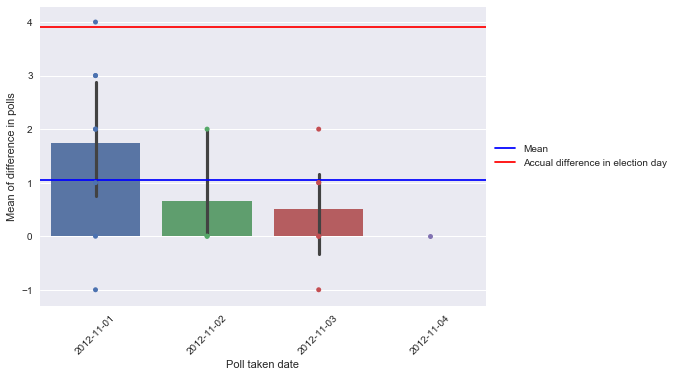

In [221]:
import matplotlib.dates as mdates

ax = sns.barplot(data=nov_election, x='StartDate', y='Diff')
sns.stripplot(data=nov_election, x='StartDate', y='Diff')

plt.axhline(y=np.mean(nov_election.Diff), c = "blue", label='Mean')
plt.axhline(3.9, 0, 1, color='r', label='Accual difference in election day');
plt.ylabel('Mean of difference in polls')
plt.xlabel('Poll taken date')

plt.xticks(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### Problem 3(c) 

Make a plot showing the differences by pollster where the pollsters are on the x-axis and the differences on the y-axis. 

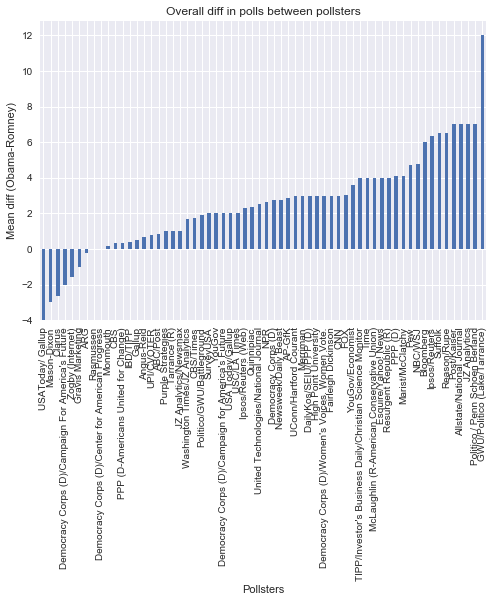

In [129]:
election.groupby(by='Pollster').Diff.mean().sort_values().plot(kind='bar')
plt.xlabel('Pollsters')
plt.ylabel('Mean diff (Obama-Romney)')
plt.title('Overall diff in polls between pollsters')

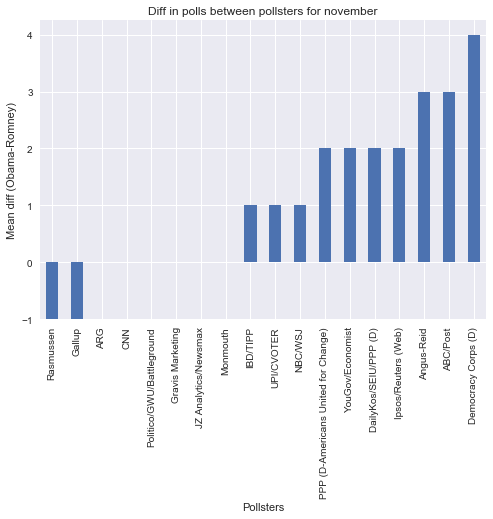

In [131]:
nov_election.groupby(by='Pollster').Diff.mean().sort_values().plot(kind='bar')
plt.xlabel('Pollsters')
plt.ylabel('Mean diff (Obama-Romney)')
plt.title('Diff in polls between pollsters for november')

Is the *across poll* difference larger than the *between pollster* difference? 

Answer: Differences across polls are greater that the ones for specific day.

#### Problem 3(d)

Take the average for each pollster and then compute the average of that. Given this difference how confident would you have been of an Obama victory?

**Hint**: Compute an estimate of the SE of this average based exclusively on the observed data. 

In [192]:
#Get only data where mean of diff between votes for Obama and Roomney
#was less than or equal to zero.
df4 = (election.groupby(by='Pollster').Diff.mean() <= 0).to_frame()
indexes = df4[df4.Diff].index

romney_pollsters = election[election.Pollster.isin(indexes)]
romney_pollsters.head(2)

,Pollster,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Other,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration,StartDate,EndDate,Diff
2,Gravis Marketing,2012-11-06T09:22:02Z,872.0,Likely Voters,Automated Phone,48.0,48.0,4.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.gravispolls.com/2012/11/gravis-mark...,Nonpartisan,None,NaN,1,2012-11-03,2012-11-05,0.0
4,Rasmussen,2012-11-06T08:47:50Z,1500.0,Likely Voters,Automated Phone,48.0,49.0,NaN,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.rasmussenreports.com/public_content...,Nonpartisan,None,NaN,1,2012-11-03,2012-11-05,-1.0


In [190]:
romney_pollsters.describe()

,Number of Observations,Obama,Romney,Undecided,Other,Question Text,Question Iteration,Diff
count,137.000000,137.000000,137.000000,45.000000,31.000000,0.0,137.0,137.000000
mean,1469.182482,45.197080,45.532847,5.755556,6.419355,NaN,1.0,-0.335766
std,668.096949,2.350968,2.670787,3.038806,4.731273,NaN,0.0,3.494276
min,590.000000,37.000000,38.000000,1.000000,1.000000,NaN,1.0,-16.000000
25%,1500.000000,44.000000,44.000000,4.000000,2.500000,NaN,1.0,-2.000000
50%,1500.000000,45.000000,46.000000,5.000000,7.000000,NaN,1.0,0.000000
75%,1500.000000,47.000000,47.000000,8.000000,10.000000,NaN,1.0,2.000000
max,8487.000000,50.000000,53.000000,15.000000,19.000000,NaN,1.0,10.000000


In [193]:
df5 = (election.groupby(by='Pollster').Diff.mean() > 0).to_frame()
indexes = df5[df5.Diff].index

obama_pollsters = election[election.Pollster.isin(indexes)]
obama_pollsters.head(2)

,Pollster,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Other,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration,StartDate,EndDate,Diff
0,Politico/GWU/Battleground,2012-11-06T08:40:26Z,1000.0,Likely Voters,Live Phone,47.0,47.0,6.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None,NaN,1,2012-11-04,2012-11-05,0.0
1,YouGov/Economist,2012-11-26T15:31:23Z,740.0,Likely Voters,Internet,49.0,47.0,3.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://cdn.yougov.com/cumulus_uploads/document...,Nonpartisan,None,NaN,1,2012-11-03,2012-11-05,2.0


In [194]:
obama_pollsters.describe()

,Number of Observations,Obama,Romney,Undecided,Other,Question Text,Question Iteration,Diff
count,427.000000,449.000000,449.000000,378.000000,171.000000,0.0,449.0,449.000000
mean,1241.332553,47.296214,44.334076,6.645503,2.824561,NaN,1.0,2.962138
std,1821.727829,2.224861,2.920023,3.765154,1.621069,NaN,0.0,3.525531
min,328.000000,39.000000,32.000000,1.000000,0.000000,NaN,1.0,-6.000000
25%,807.500000,46.000000,43.000000,4.000000,2.000000,NaN,1.0,1.000000
50%,1000.000000,47.000000,45.000000,6.000000,2.000000,NaN,1.0,3.000000
75%,1140.000000,49.000000,46.000000,8.000000,4.000000,NaN,1.0,5.000000
max,36472.000000,54.000000,51.000000,28.000000,8.000000,NaN,1.0,18.000000


In [197]:
obama_pollsters['Number of Observations'].sum()
romney_pollsters['Number of Observations'].sum()

obama_pollsters['Number of Observations'].sum() - romney_pollsters['Number of Observations'].sum()

530049.0

201278.0

328771.0

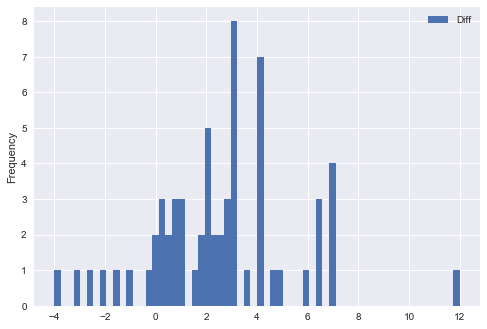

In [201]:
election.groupby(by='Pollster').Diff.mean().to_frame().plot(kind='hist', bins=62)

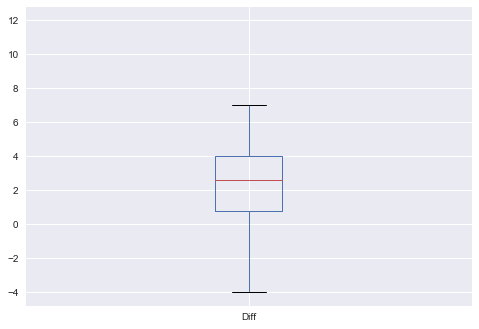

In [188]:
election.groupby(by='Pollster').Diff.mean().to_frame().plot(kind='box')

In [205]:
pollstersDiffMean = election.groupby(by='Pollster').Diff.mean().to_frame()
pollstersDiffMean.describe()

,Diff
count,62.000000
mean,2.527056
std,2.777974
min,-4.000000
25%,0.797619
50%,2.583333
75%,4.000000
max,12.000000


In [209]:
pollstersDiffMean[pollstersDiffMean.Diff > 0].count() / pollstersDiffMean.count() * 100

Diff    85.483871
dtype: float64

Given this difference how confident would you have been of an Obama victory?

Answer: More than 85% of polls said that obama will win. Mean of difference in Obama - Romney votes was ~2.53, median ~2.57 and std ~2.78. I wouldn't be sure of Obama win.

#### Problem 3(e)

**For AC209 Students**: Show the difference against time and see if you can detect a trend towards the end. Use this trend to see if it improves the final estimate.

In [35]:
#your code here

Answer: 

## Discussion for Problem 3

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

---


## Problem 4

In this last problem, we will use the polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to create a preliminary prediction of the result of each state. 

The HuffPost Pollster API allows you to access the data as a CSV or a JSON response by tacking ".csv" or ".json" at the end of the URLs. For example the 2012 Presidential Election could be accessed as a [.json](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.json) instead of a [.csv](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv)

#### Problem 4(a)

Read in the polls for **all** of the 2014 Senate Elections using the HuffPost API. For example, we can consider the [2014 Senate race in Kentucky between Mitch McConnell and Alison Grimes](http://elections.huffingtonpost.com/pollster/2014-kentucky-senate-mcconnell-vs-grimes). 

To search for the 2014 Senate races, use the `topics` parameter in the API [[read more about topics here](http://elections.huffingtonpost.com/pollster/api)].  

In [225]:
url_str = "http://elections.huffingtonpost.com/pollster/api/charts/?topic=2014-senate"

To list all the URLs related to the 2014 Senate races using the pollster API, we can use a list comprehension:

In [226]:
election_urls = [election['url'] + '.csv' for election in requests.get(url_str).json()]
election_urls

['http://elections.huffingtonpost.com/pollster/2014-delaware-senate-wade-vs-coons.csv',
 'http://elections.huffingtonpost.com/pollster/2014-massachusetts-senate-herr-vs-markey.csv',
 'http://elections.huffingtonpost.com/pollster/2014-rhode-island-senate-zaccaria-vs-reed.csv',
 'http://elections.huffingtonpost.com/pollster/2014-montana-senate-daines-vs-curtis.csv',
 'http://elections.huffingtonpost.com/pollster/2014-oklahoma-senate-lankford-vs-johnson.csv',
 'http://elections.huffingtonpost.com/pollster/2014-hawaii-senate-cavasso-vs-schatz.csv',
 'http://elections.huffingtonpost.com/pollster/2014-kansas-senate-roberts-vs-orman-vs-taylor.csv',
 'http://elections.huffingtonpost.com/pollster/2014-wyoming-senate.csv',
 'http://elections.huffingtonpost.com/pollster/2014-tennessee-senate-alexander-vs-ball.csv',
 'http://elections.huffingtonpost.com/pollster/2014-idaho-senate-risch-vs-mitchell.csv',
 'http://elections.huffingtonpost.com/pollster/2014-new-jersey-senate-bell-vs-booker.csv',
 'ht

Because there so many Senate races, we can create a dictionary of pandas DataFrames that will be keyed by the name of the election (a string). 

In [230]:
def build_frame(url):
    """
    Returns a pandas DataFrame object containing
    the data returned from the given url
    """
    source = requests.get(url).text
    
    # Use StringIO because pd.DataFrame.from_csv requires .read() method
    s = StringIO(source)
    
    return pd.DataFrame.from_csv(s, index_col=None).convert_objects(
            convert_dates="coerce", convert_numeric=True)

In [231]:
# Makes a dictionary of pandas DataFrames keyed on election string.
dfs = dict((election.split("/")[-1][:-4], build_frame(election)) for election in election_urls)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Show the head of the DataFrame containing the polls for the 2014 Senate race in Kentucky between McConnell and Grimes.

In [237]:
senateRace = dfs.get('2014-kentucky-senate-mcconnell-vs-grimes')
senateRace.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Grimes,McConnell,Undecided,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration
0,PPP (D),2014-10-30,2014-11-01,2014-11-02 01:44:58,1503,Likely Voters,IVR/Online,42.0,50.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.publicpolicypolling.com/pdf/2014/PP...,Pollster,Dem,NaN,1
1,NBC/Marist,2014-10-27,2014-10-30,2014-11-02 14:37:22,556,Likely Voters,Live Phone,41.0,50.0,3.0,http://elections.huffingtonpost.com/pollster/p...,http://newscms.nbcnews.com/sites/newscms/files...,Nonpartisan,None,NaN,1
2,SurveyUSA/Courier-Journal/Herald-Leader/WHAS/WKYT,2014-10-25,2014-10-29,2014-10-30 23:33:59,597,Likely Voters,IVR/Online,43.0,48.0,6.0,http://elections.huffingtonpost.com/pollster/p...,http://www.surveyusa.com/client/PollReport.asp...,Nonpartisan,None,NaN,1
3,POS (R-Crossroads GPS),2014-10-25,2014-10-27,2014-10-30 20:56:18,600,Likely Voters,Live Phone,43.0,50.0,NaN,http://elections.huffingtonpost.com/pollster/p...,https://www.crossroadsgps.org/wp-content/uploa...,Sponsor,Rep,NaN,1
4,CBS/NYT/YouGov,2014-10-16,2014-10-23,2014-10-26 15:00:07,1502,Likely Voters,Internet,39.0,45.0,14.0,http://elections.huffingtonpost.com/pollster/p...,https://today.yougov.com/news/2014/09/07/battl...,Nonpartisan,None,NaN,1


In [303]:
senateRace = dfs.get(race)
senateRace = senateRace.iloc[:,7:9]
senateRace['Diff'] = senateRace.iloc[:,0] - senateRace.iloc[:,1]

raceData = {'RaceName': race, 'Candidate1': senateRace.columns[0],\
            'Candidate2': senateRace.columns[1], 'MeanOfDiffs': senateRace.Diff.mean()}
if raceData['MeanOfDiffs'] > 0:
    raceData['Winner'] = raceData['Candidate1']
else:
    raceData['Winner'] = raceData['Candidate2']

In [308]:
raceData

{'Candidate1': 'Grimes',
 'Candidate2': 'McConnell',
 'MeanOfDiffs': -3.0,
 'RaceName': '2014-kentucky-senate-mcconnell-vs-grimes',
 'Winner': 'McConnell'}

#### Problem 4(b)

For each 2014 Senate race, create a preliminary prediction of the result for that state.

In [315]:
df5 = pd.DataFrame()
for race in dfs:
    senateRace = dfs.get(race)
    senateRace = senateRace.iloc[:,7:9]
    senateRace['Diff'] = senateRace.iloc[:,0] - senateRace.iloc[:,1]

    raceData = {'RaceName': race, 'Candidate1': senateRace.columns[0],\
                'Candidate2': senateRace.columns[1],\
                'MeanOfDiffs': np.round(np.mean(senateRace.Diff), 3)}
    raceData['Winner'] =np.where(raceData['MeanOfDiffs'] > 0,\
                                 raceData['Candidate1'], raceData['Candidate2'])
    df5 = df5.append(raceData, ignore_index=True)
df5

,Candidate1,Candidate2,MeanOfDiffs,RaceName,Winner
0,Coons,Wade,17.400,2014-delaware-senate-wade-vs-coons,Coons
1,Markey,Herr,22.462,2014-massachusetts-senate-herr-vs-markey,Markey
2,Zaccaria,Reed,-35.500,2014-rhode-island-senate-zaccaria-vs-reed,Reed
3,Curtis,Daines,-17.143,2014-montana-senate-daines-vs-curtis,Daines
4,Lankford,Johnson,31.125,2014-oklahoma-senate-lankford-vs-johnson,Lankford
5,Schatz,Cavasso,40.375,2014-hawaii-senate-cavasso-vs-schatz,Schatz
6,Taylor,Roberts,-18.375,2014-kansas-senate-roberts-vs-orman-vs-taylor,Roberts
7,Hardy,Enzi,-44.800,2014-wyoming-senate,Enzi
8,Alexander,Ball,19.000,2014-tennessee-senate-alexander-vs-ball,Alexander
9,Risch,Mitchell,29.833,2014-idaho-senate-risch-vs-mitchell,Risch


# Submission Instructions

To submit your homework, create a folder named **lastname_firstinitial_hw#** and place your IPython notebooks, data files, and any other files in this folder. Your IPython Notebooks should be completely executed with the results visible in the notebook. We should not have to run any code.  Compress the folder (please use .zip compression) and submit to the CS109 dropbox in the appropriate folder. *If we cannot access your work because these directions are not followed correctly, we will not grade your work.*
